# Basic QS Optimization

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

This tutorial demonstrates how to perform optimization with DESC. It will go through two examples: 

1) targeting the "triple product" quasi-symmetry objective $f_T$ in the full plasma volume
2) targeting the "two-term" objective $f_C$ for quasi-helical symmetry at the plasma boundary surface

These examples are adapted from a problem first presented in [Rodriguez et al. (2022)](https://www.cambridge.org/core/journals/journal-of-plasma-physics/article/measures-of-quasisymmetry-for-stellarators/01B9DFE86A23964F331E0E0615B4E7A2) and reproduced in [Dudt et al. (2023)](https://www.cambridge.org/core/journals/journal-of-plasma-physics/article/desc-stellarator-code-suite-part-3-quasisymmetry-optimization/0B262B685969D2F5697BEE28C8A78DB1).

If you have access to a GPU, uncomment the following two lines before any DESC or JAX related imports. You should see about an order of magnitude speed improvement with only these two lines of code!

In [2]:
# from desc import set_device
# set_device("gpu")

As mentioned in [DESC Documentation on performance tips](https://desc-docs.readthedocs.io/en/latest/performance_tips.html), one can use compilation cache directory to reduce the compilation overhead time. Note: One needs to create `jax-caches` folder manually.

In [3]:
# import jax

# jax.config.update("jax_compilation_cache_dir", "../jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 20

import desc.io
from desc.grid import LinearGrid, ConcentricGrid
from desc.objectives import (
    ObjectiveFunction,
    FixBoundaryR,
    FixBoundaryZ,
    FixPressure,
    FixIota,
    FixPsi,
    AspectRatio,
    ForceBalance,
    QuasisymmetryBoozer,
    QuasisymmetryTwoTerm,
    QuasisymmetryTripleProduct,
)
from desc.optimize import Optimizer
from desc.plotting import (
    plot_grid,
    plot_boozer_modes,
    plot_boozer_surface,
    plot_qs_error,
    plot_boundaries,
    plot_boundary,
)

ERROR:2025-10-14 17:48:07,181:jax._src.xla_bridge:444: Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/home/dpanici/.conda/envs/desc-env/lib/python3.12/site-packages/jax/_src/xla_bridge.py", line 442, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/home/dpanici/.conda/envs/desc-env/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 324, in initialize
    _check_cuda_versions(raise_on_first_error=True)
  File "/home/dpanici/.conda/envs/desc-env/lib/python3.12/site-packages/jax_plugins/xla_cuda12/__init__.py", line 281, in _check_cuda_versions
    local_device_count = cuda_versions.cuda_device_count()
                         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: jaxlib/cuda/versions_helpers.cc:113: operation cuInit(0) failed: Unknown CUDA error 303; cuGetErrorName failed. This probably means that JAX was unable to load the CUDA libraries.
/home/dpanici/DE

## Initial guess

To save time during this tutorial, we will load an equilibrium solution to use as the initial guess for optimization. This equilibrium is already somewhat close to quasi-helical symmetry (QH) but can be improved. 

In [5]:
# load initial equilibrium
eq_init = desc.io.load("qs_initial_guess.h5")

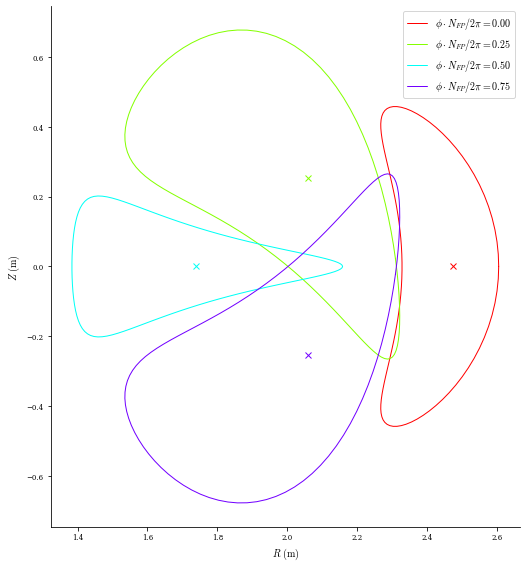

In [6]:
plot_boundary(eq_init, figsize=(8, 8));

There are several plotting functions available in DESC that are useful for visualizing the quasi-symmetry (QS) errors. Let us look at the initial errors before optimization: 

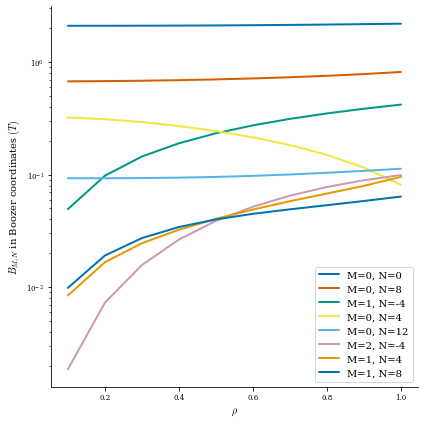

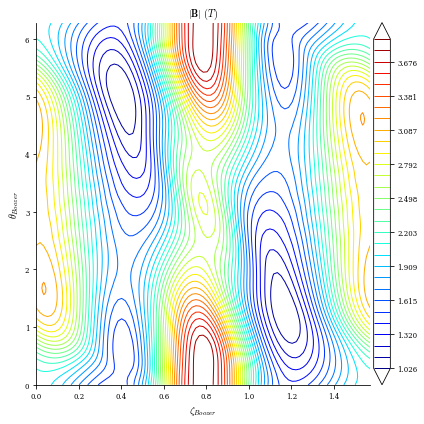

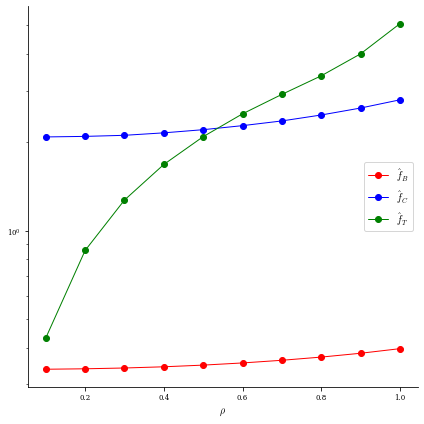

In [7]:
# plot modes of |B| in Boozer coordinates
plot_boozer_modes(eq_init, num_modes=8, rho=10)

# plot |B| contours in Boozer coordinates on a surface (default is rho=1)
plot_boozer_surface(eq_init)

# plot normalized QS metrics
plot_qs_error(eq_init, helicity=(1, eq_init.NFP), rho=10);

## QS metrics

The last plot shows the three different QS errors implemented in DESC. Their definitions and the normalized scalar quantities plotted for each flux surface are shown below: 

### Boozer Coordinates

This is the "traditional" definition of QS. The drawbacks of this metric are that Boozer coordinates are expensive to compute, and it only provides "global" information about the error on each surface. But it has the nice property of $\hat{f}_B \in [0,1]$. 

\begin{equation}
|\mathbf{B}| = B(\psi, M\vartheta_{B} - N\zeta_{B})
\end{equation}

\begin{equation}
\mathbf{f}_{B} = \{ B_{mn} ~|~ m/n \neq M/N \}
\end{equation}

\begin{equation}
\hat{f}_{B} = \frac{|\mathbf{f}_{B}|}{\sqrt{\sum_{m,n} B_{mn}^2}}
\end{equation}

### Two-Term

This definition is advantageous because it does not require a transformation to Boozer coordinates, and it reveals "local" errors within a flux surface.

\begin{equation}
f_{C} = \left( M \iota - N \right) \left( \mathbf{B} \times \nabla \psi \right) \cdot \nabla B - \left( M G + N I \right) \mathbf{B} \cdot \nabla B. 
\end{equation}

\begin{equation}
\mathbf{f}_{C} = \{ f_{C}(\theta_{i},\zeta_{j}) ~|~ i \in [0,2\pi), j \in [0,2\pi/N_{FP}) \}
\end{equation}

\begin{equation}
\hat{f}_{C} = \frac{\langle |f_C| \rangle}{\langle B \rangle^3}.
\end{equation}

### Triple Product

This is also a local error metric that can be evaluated without Boozer coordinates. The potential advantages of this definition are that it does not require specifying the helicity (type of quasi-symmetry) and does not assume $\mathbf{J}\cdot\nabla\psi=0$. 

\begin{equation}
f_{T} = \nabla \psi \times \nabla B \cdot \nabla \left( \mathbf{B} \cdot \nabla B \right)
\end{equation}

\begin{equation}
\mathbf{f}_{T} = \{ f_{T}(\theta_{i},\zeta_{j}) ~|~ i \in [0,2\pi), j \in [0,2\pi/N_{FP}) \}
\end{equation}

\begin{equation}
\hat{f}_{T}(\psi) = \frac{\langle R \rangle^2 \langle |f_{T}| \rangle}{\langle B \rangle^4}
\end{equation}

## Optimizer

To set up the optimization problem, we need to choose an optimization algorithm. `"proximal-lsq-exact"` is a custom least-squares routine (with `proximal` referring to the proximal projection done at each step to ensure force balance i.e. it perturbs the boundary in the direction to optimize the objective function, then resolves the equilibrium to ensure force balance), but there are other options available ([see documentation](https://desc-docs.readthedocs.io/en/latest/_api/optimize/desc.optimize.Optimizer.html)). 

In [8]:
optimizer = Optimizer("proximal-lsq-exact")

## Specifying constraints

Next we need to define the optimization constraints. In DESC, we explicitly specify the constraints, and all other parameters become free variables for optimization. In this example, we would like the following 4 stellarator-symmetric boundary coefficients to be our only optimization variables:

$R^{b}_{1,2} \cos(\theta) \cos(2N_{FP}\phi)$

$R^{b}_{-1,-2} \sin(\theta) \sin(2N_{FP}\phi)$

$Z^{b}_{-1,2} \sin(\theta) \cos(2N_{FP}\phi)$

$Z^{b}_{1,-2} \cos(\theta) \sin(2N_{FP}\phi)$

We will fix all other boundary modes besides these. We will also fix the pressure profile, rotational transform profile, and total toroidal magnetic flux. Finally, we also specify equilibrium force balance as a constraint by including the `ForceBalance()` objective in the list of constraints.

In [9]:
# indices of boundary modes we want to optimize
idx_Rcc = eq_init.surface.R_basis.get_idx(M=1, N=2)
idx_Rss = eq_init.surface.R_basis.get_idx(M=-1, N=-2)
idx_Zsc = eq_init.surface.Z_basis.get_idx(M=-1, N=2)
idx_Zcs = eq_init.surface.Z_basis.get_idx(M=1, N=-2)
print("surface.R_basis.modes is an array of [l,m,n] of the surface modes:")
print(eq_init.surface.R_basis.modes[0:10])

# boundary modes to constrain
R_modes = np.delete(eq_init.surface.R_basis.modes, [idx_Rcc, idx_Rss], axis=0)
Z_modes = np.delete(eq_init.surface.Z_basis.modes, [idx_Zsc, idx_Zcs], axis=0)

eq_qs_T = eq_init.copy()  # make a copy of the original one
# constraints
constraints = (
    ForceBalance(eq=eq_qs_T),  # enforce JxB-grad(p)=0 during optimization
    FixBoundaryR(eq=eq_qs_T, modes=R_modes),  # fix specified R boundary modes
    FixBoundaryZ(eq=eq_qs_T, modes=Z_modes),  # fix specified Z boundary modes
    FixPressure(eq=eq_qs_T),  # fix pressure profile
    FixIota(eq=eq_qs_T),  # fix rotational transform profile
    FixPsi(eq=eq_qs_T),  # fix total toroidal magnetic flux
)

surface.R_basis.modes is an array of [l,m,n] of the surface modes:
[[ 0 -8 -4]
 [ 0 -7 -4]
 [ 0 -6 -4]
 [ 0 -5 -4]
 [ 0 -4 -4]
 [ 0 -3 -4]
 [ 0 -2 -4]
 [ 0 -1 -4]
 [ 0 -8 -3]
 [ 0 -7 -3]]


## Optimizing for Triple Product QS in Volume

First we are going to optimize for QS using the "triple product" objective, evaluated throughout the plasma volume. We start by creating the grid of collocation points where we want the $f_T$ errors to be evaluated. We then initialize the appropriate objective function with this grid. 

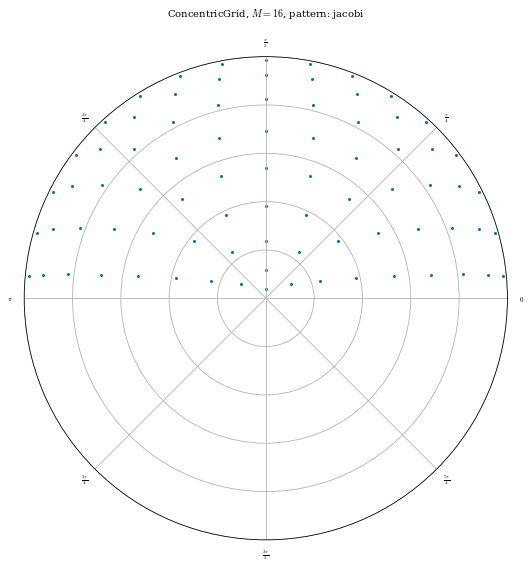

In [10]:
# objective
grid_vol = ConcentricGrid(
    L=eq_init.L_grid,
    M=eq_init.M_grid,
    N=eq_init.N_grid,
    NFP=eq_init.NFP,
    sym=eq_init.sym,
)
plot_grid(grid_vol, figsize=(8, 8))

objective_fT = ObjectiveFunction(QuasisymmetryTripleProduct(eq=eq_qs_T, grid=grid_vol))

We are now ready to run the optimization problem. The syntax is shown below with many of the optimization options that are available -- you can try changing these parameters. 

In [11]:
eq_qs_T, result_T = eq_qs_T.optimize(
    objective=objective_fT,
    constraints=constraints,
    optimizer=optimizer,
    ftol=5e-2,  # stopping tolerance on the function value
    xtol=1e-6,  # stopping tolerance on the step size
    gtol=1e-6,  # stopping tolerance on the gradient
    maxiter=50,  # maximum number of iterations
    options={
        "perturb_options": {"order": 2, "verbose": 0},  # use 2nd-order perturbations
        "solve_options": {
            "ftol": 5e-3,
            "xtol": 1e-6,
            "gtol": 1e-6,
            "verbose": 0,
        },  # for equilibrium subproblem
    },
    copy=False,  # copy=False we will overwrite the eq_qs_T object with the optimized result
    verbose=3,
)

Building objective: QS triple product
Precomputing transforms
Timer: Precomputing transforms = 652 ms
Timer: Objective build = 1.12 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 251 ms
Timer: Objective build = 284 ms
Timer: Objective build = 1.78 ms
Timer: Eq Update LinearConstraintProjection build = 7.54 sec
Timer: Proximal projection build = 19.5 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Timer: Objective build = 607 ms
Timer: LinearConstraintProjection build = 1.34 sec
Number of parameters: 4
Number of objectives: 1377
Timer: Initializing the optimization = 21.5 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          2.366e+02                                    2.127e+01   
       1              2          7

If you would like to store the objective values before and after optimization, you can access them through `result` that is returned by optimization.

In [12]:
# info["Objective values"] is a dictionary of the objective values
for key in result_T["Objective values"].keys():
    if isinstance(result_T["Objective values"][key], dict):
        for subkey in result_T["Objective values"][key].keys():
            print(key, subkey, result_T["Objective values"][key][subkey])
    # if there are multiple instances of the same objective type,
    # there will be a list of dictionaries, each storing the values of the objective
    elif isinstance(result_T["Objective values"][key], list):
        for i in range(len(result_T["Objective values"][key])):
            for subkey in result_T["Objective values"][key][i].keys():
                print(key, subkey, result_T["Objective values"][key][i][subkey])

Total (sum of squares) f 0.005625044599996705
Total (sum of squares) f0 236.72435584051982
Quasi-symmetry error:  f_max 2.086172618747741
Quasi-symmetry error:  f0_max 473.01432460840067
Quasi-symmetry error:  f_min 2.5142169316172445e-05
Quasi-symmetry error:  f0_min 0.000442157503337623
Quasi-symmetry error:  f_mean 0.10811726291657078
Quasi-symmetry error:  f0_mean 11.171841092895546
Quasi-symmetry error:  f_max_norm 0.03545309027135038
Quasi-symmetry error:  f0_max_norm 8.038557978989205
Quasi-symmetry error:  f_min_norm 4.272741336806995e-07
Quasi-symmetry error:  f0_min_norm 7.5141672070230394e-06
Quasi-symmetry error:  f_mean_norm 0.0018373796337013482
Quasi-symmetry error:  f0_mean_norm 0.18985787043900454
Force error:  f_max 16114.099037048816
Force error:  f0_max 151574.97746978689
Force error:  f_min 0.2796769850632805
Force error:  f0_min 2.4310919536752627
Force error:  f_mean 744.6671866520912
Force error:  f0_mean 5922.427405369969
Force error:  f_max_norm 0.001208230947

Let us plot the QS errors again to see how well the optimization worked: 

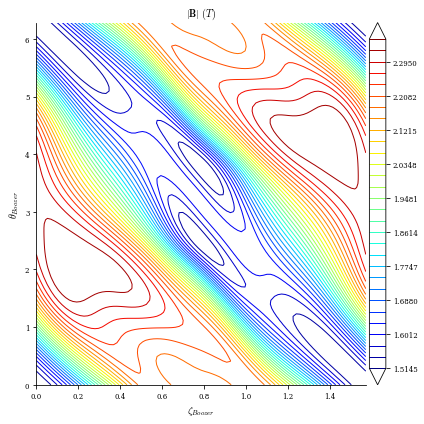

In [13]:
# |B| contours at rho=1 surface
plot_boozer_surface(eq_qs_T);

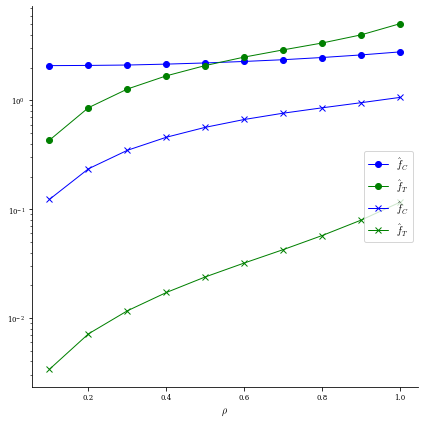

In [14]:
# compare f_T & f_C before (o) vs after (x) optimization
fig, ax = plot_qs_error(
    eq_init, helicity=(1, eq_init.NFP), fB=False, legend=False, rho=10
)
plot_qs_error(
    eq_qs_T, helicity=(1, eq_init.NFP), fB=False, ax=ax, marker=["x", "x"], rho=10
);

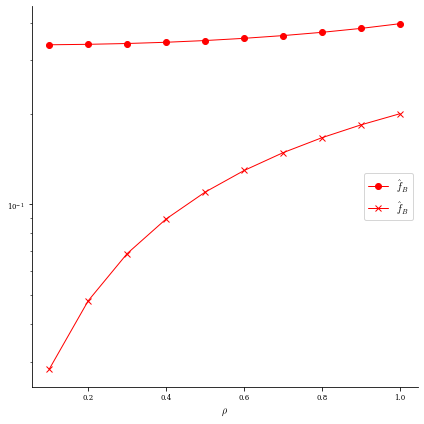

In [15]:
# compare f_B before (o) vs after (x) optimization
fig, ax = plot_qs_error(
    eq_init, helicity=(1, eq_init.NFP), fT=False, fC=False, legend=False, rho=10
)
plot_qs_error(
    eq_qs_T, helicity=(1, eq_init.NFP), fT=False, fC=False, ax=ax, marker=["x"], rho=10
);

## Optimizing for Two-Term QH at Boundary Surface

Next we are going to optimize for QH using the "two-term" objective, evaluated at the $\rho=1$ flux surface. Again we need to create the grid of collocation points where we want the $f_C$ errors to be evaluated. We then initialize the appropriate objective function with this grid. 

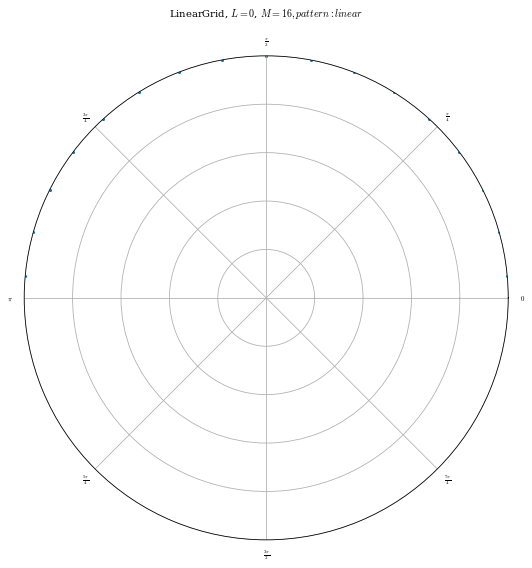

In [16]:
grid_rho1 = LinearGrid(
    M=eq_init.M_grid,
    N=eq_init.N_grid,
    NFP=eq_init.NFP,
    sym=eq_init.sym,
    rho=np.array(1.0),
)
plot_grid(grid_rho1, figsize=(8, 8))

eq_qs_C = eq_init.copy()
# constraints
constraints = (
    ForceBalance(eq=eq_qs_C),  # enforce JxB-grad(p)=0 during optimization
    FixBoundaryR(eq=eq_qs_C, modes=R_modes),  # fix specified R boundary modes
    FixBoundaryZ(eq=eq_qs_C, modes=Z_modes),  # fix specified Z boundary modes
    FixPressure(eq=eq_qs_C),  # fix pressure profile
    FixIota(eq=eq_qs_C),  # fix rotational transform profile
    FixPsi(eq=eq_qs_C),  # fix total toroidal magnetic flux
)
# two-term objective
objective_fC = ObjectiveFunction(
    QuasisymmetryTwoTerm(eq=eq_qs_C, grid=grid_rho1, helicity=(1, eq_init.NFP))
)

Now we can re-run the optimization from the same intial guess as before, but using this different objective function. We can reuse the same `optimizer` from the first run. 

In [17]:
eq_qs_C, result_C = eq_qs_C.optimize(
    objective=objective_fC,
    constraints=constraints,
    optimizer=optimizer,
    ftol=1e-2,
    xtol=1e-6,
    gtol=1e-6,
    maxiter=50,
    options={
        "perturb_options": {"order": 2, "verbose": 0},
        "solve_options": {"ftol": 1e-2, "xtol": 1e-6, "gtol": 1e-6, "verbose": 0},
    },
    copy=False,
    verbose=3,
)

Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 57.4 ms
Timer: Objective build = 99.2 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 64.0 ms
Timer: Objective build = 73.2 ms
Timer: Objective build = 1.60 ms
Timer: Eq Update LinearConstraintProjection build = 67.7 ms
Timer: Proximal projection build = 1.46 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed iota
Building objective: fixed Psi
Timer: Objective build = 70.1 ms
Timer: LinearConstraintProjection build = 72.0 ms
Number of parameters: 4
Number of objectives: 289
Timer: Initializing the optimization = 1.63 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          5.218e+04                                    2.674e+02   
       1              2          3.641e+

Let us plot the QS errors again for this case. Was one objective more effective than the other at improving quasi-symmetry for this example? 

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


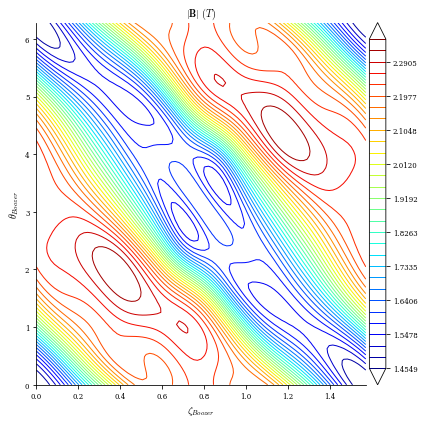

In [18]:
# |B| contours at rho=1 surface
plot_boozer_surface(eq_qs_C);

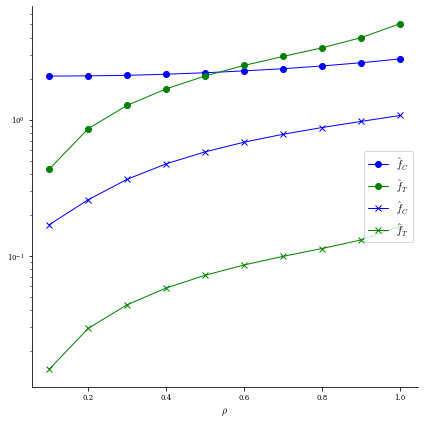

In [19]:
# compare f_T & f_C before (o) vs after (x) optimization
fig, ax = plot_qs_error(
    eq_init, helicity=(1, eq_init.NFP), fB=False, legend=False, rho=10
)
plot_qs_error(
    eq_qs_C, helicity=(1, eq_init.NFP), fB=False, ax=ax, marker=["x", "x"], rho=10
);

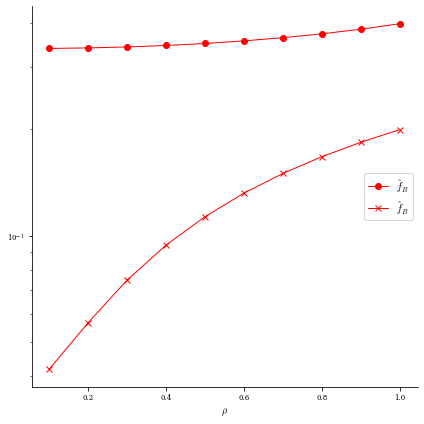

In [20]:
# compare f_B before (o) vs after (x) optimization
fig, ax = plot_qs_error(
    eq_init, helicity=(1, eq_init.NFP), fT=False, fC=False, legend=False, rho=10
)
plot_qs_error(
    eq_qs_C, helicity=(1, eq_init.NFP), fT=False, fC=False, ax=ax, marker=["x"], rho=10
);

## Combining Multiple Objectives

It is very easy in DESC to combine multiple optimization objectives with relative weights between them. Here is an example of how to create an objective optimizing for both $f_B$ and a target aspect ratio: 

In [21]:
objective = ObjectiveFunction(
    (
        QuasisymmetryBoozer(eq=eq_init, helicity=(1, eq_init.NFP), weight=1e-2),
        AspectRatio(eq=eq_init, target=6, weight=1e1),
    )
)